In [3]:
# Replicating Load Data logic

import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

path1 = Path("Data/batch1.pkl")
batch1 = pickle.load(open(path1, 'rb'))

#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())
numBat1

41

In [2]:
# randomly selected sample cell
qd_sample = None
while not qd_sample:
    idx = np.random.choice(numBat1, 1)
    idx_key = "b1c" + str(*idx)
    print(idx_key)
    if idx_key in batch1.keys():
        qd_sample = batch1[idx_key]
idx_key

b1c0


'b1c0'

### V over Qd

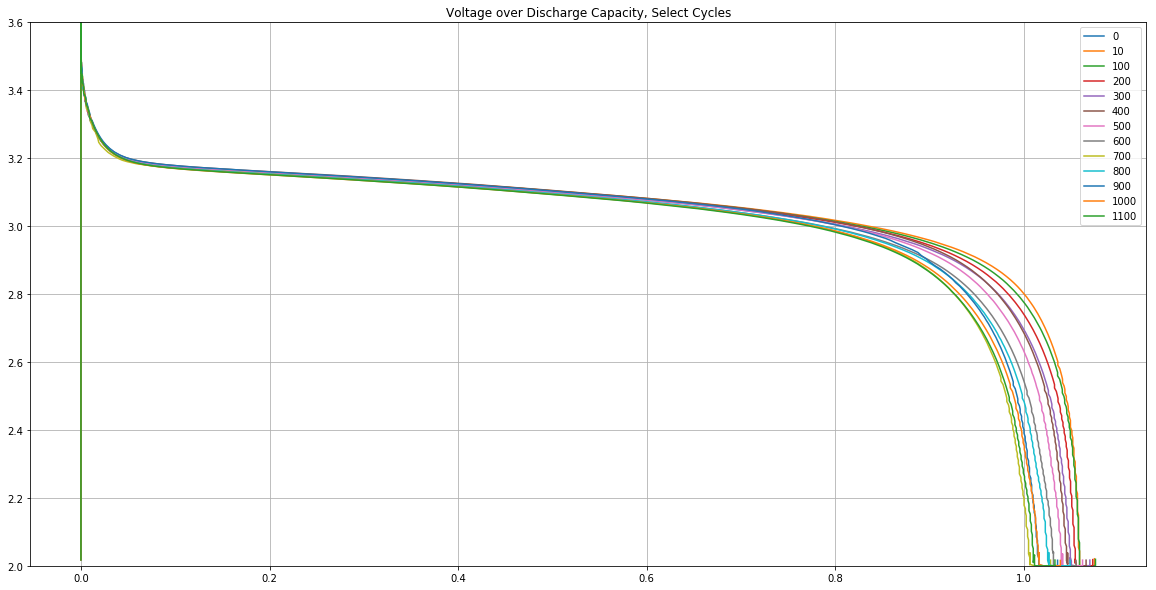

In [3]:
plt.figure(figsize=(20,10))
for i, cycle in qd_sample["cycles"].items():
    if (int(i)==10) | (int(i) % 100 == 0):
        plt.plot(cycle["Qd"], cycle["V"], label=i)
plt.title('Voltage over Discharge Capacity, Select Cycles')
plt.ylim(2,3.6)
plt.grid()
plt.legend()
plt.show()

### Qdlin over evenly spaced 1000 voltage points(?)

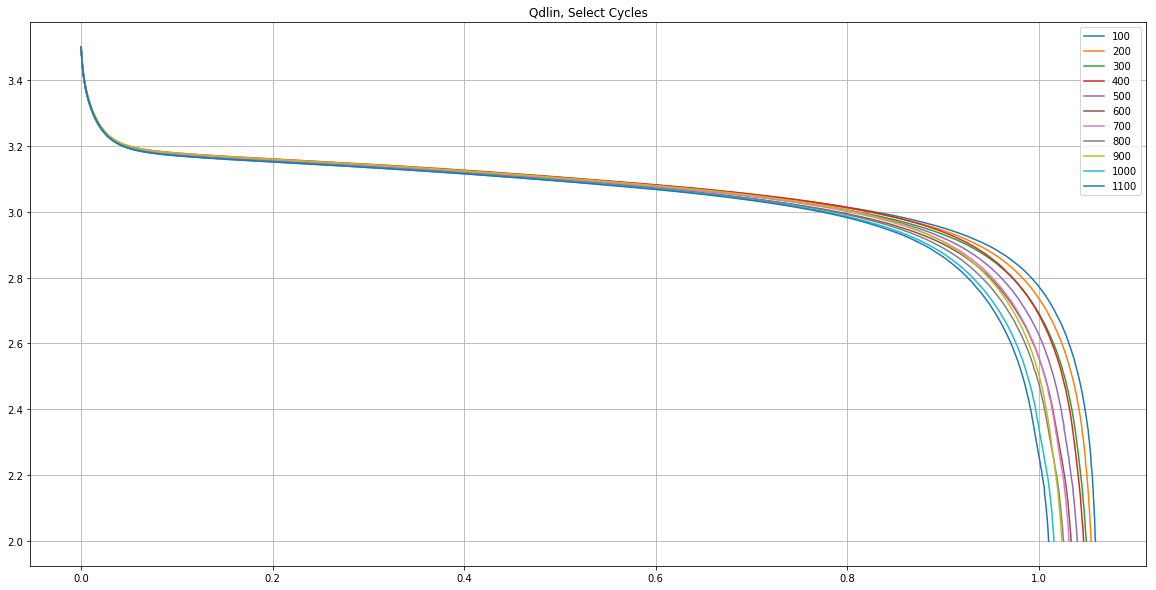

In [4]:
plt.figure(figsize=(20,10))
v_space = np.linspace(3.5, 2.0, 1000)
for i, cycle in qd_sample["cycles"].items():
    if (int(i)>0) & (int(i) % 100 == 0):
        plt.plot(cycle["Qdlin"], v_space, label=i)
plt.title('Qdlin, Select Cycles')
plt.grid()
plt.legend()
plt.show()

### delta(Q_100, Q_10) over V:  _Done Using Qdlin !!!_

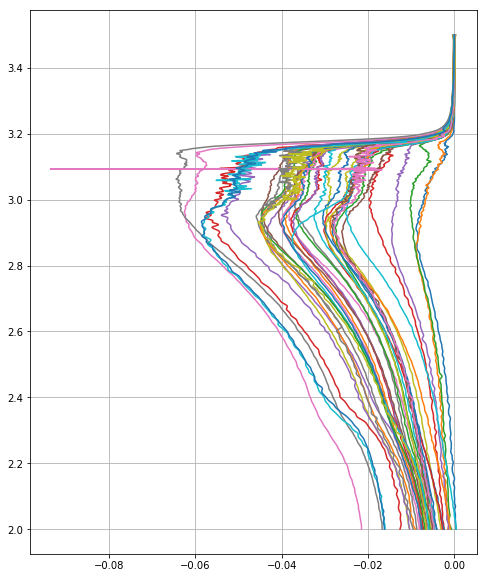

In [6]:
v_space = np.linspace(3.5,2,1000)   # does this make sense?
plt.figure(figsize=(8,10))
for cell in batch1.values():
    c10 = cell['cycles']['10']
    c100 = cell['cycles']['100']
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    plt.plot(dQ_100_10, v_space)
plt.grid()
plt.show()

## Variance Model

In [41]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [97]:
variances = np.array([])
cycle_life = np.array([])
for cell in batch1.values():
    c10 = cell['cycles']['10']
    c100 = cell['cycles']['100']
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    variances = np.append(variances, np.log(np.var(dQ_100_10)))
    cycle_life = np.append(cycle_life, cell["cycle_life"])
    
df = pd.DataFrame({"Delta_Qd_100_10_variance": variances, 
                   "cycles": cycle_life})

df.head()

,Delta_Qd_100_10_variance,cycles
0,-11.631570,1190.0
1,-11.825562,1179.0
2,-11.402131,1177.0
3,-10.099939,1226.0
4,-10.602896,1227.0


In [78]:
x_train, x_test, y_train, y_test = train_test_split(df.Delta_Qd_100_10_variance,
                                                    df.cycles,
                                                    test_size=0.2,
                                                    random_state=54)
regr = ElasticNet(random_state=54)
regr.fit(x_train[:,np.newaxis], y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=54, selection='cyclic', tol=0.0001, warm_start=False)

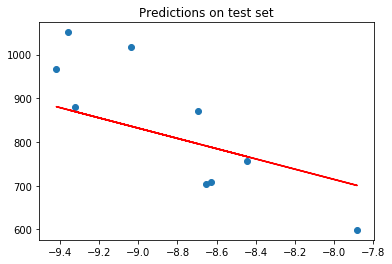

In [95]:
pred_test = regr.predict(x_test[:,np.newaxis])

plt.scatter(x_test, y_test)
plt.plot(x_test, pred_test, color="red")
plt.title("Predictions on test set")
plt.show()

In [98]:
mean_squared_error(pred_test, y_test)

11287.15168134802

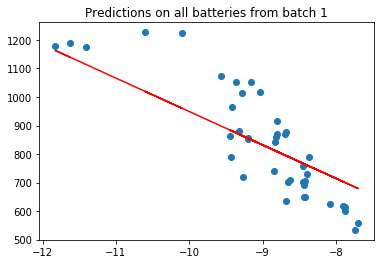

In [96]:
pred_all = regr.predict(df["Delta_Qd_100_10_variance"][:,np.newaxis])

plt.scatter(df["Delta_Qd_100_10_variance"], df["cycles"])
plt.plot(df["Delta_Qd_100_10_variance"], pred_all, color="red")
plt.title("Predictions on all batteries from batch 1")
plt.show()